# FOML-PROJECT-S024-S050
# CANTEEN EMPTY TABLE DETECTION

## Importing Libraries



In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


## Capturing Frames every 1 second from video, and cropping images to ensure tables are centered


In [1]:
video_path = 'PXL_20231023_093126313.TS.mp4'
save_dir = 'C:/Users/HP/OneDrive - Shri Vile Parle Kelavani Mandal/Desktop/FOML/FomlProject/frames_dir/'

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
frame_count = 0

while True:
    ret, frame = cap.read()
    
    if not ret:
        break

    frame_count += 1

    if frame_count % (1 * frame_rate) == 0:
        
        
        x1, y1 = 150, 500  
        x2, y2 = 920, 1200  
        
        cropped_frame = frame[y1:y2, x1:x2]
        
        save_path = os.path.join(save_dir, f'frame_{frame_count}.jpg')
        cv2.imwrite(save_path, cropped_frame)

cap.release()

print("Frames extracted and saved.")


Frames extracted and saved.


## Applying Thresholding to see whether it can be used for labelling

In [3]:
save_dir = 'C:/Users/HP/OneDrive - Shri Vile Parle Kelavani Mandal/Desktop/FOML/FomlProject/frames_dir/'

# Loop through each frame saved in the directory
for frame_file in os.listdir(save_dir):
    frame_path = os.path.join(save_dir, frame_file)
    image = cv2.imread(frame_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a binary threshold. The threshold value of 127 is chosen arbitrarily, you might need to adjust this.
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Calculate the area of the contour
        area = cv2.contourArea(contour)

        # Filter out very small contours which are not tables
        if area > 200:  # 5000 is an arbitrary value, you might need to adjust based on your image scale
            # Get bounding box around the contour
            x, y, w, h = cv2.boundingRect(contour)

            # Extract the region within the bounding box
            region = gray[y:y+h, x:x+w]

            # Check occupancy by calculating mean intensity in the region
            # If it's below a threshold, the table might be considered unoccupied.
            mean_intensity = np.mean(region)
            if mean_intensity < 127:  # This value might also need adjustment.
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)  # Draw a green rectangle for unoccupied
            else:
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)  # Draw a red rectangle for occupied

    # Save or display the processed image
    processed_frame_path = os.path.join(save_dir, f'processed_{frame_file}')
    cv2.imwrite(processed_frame_path, image)


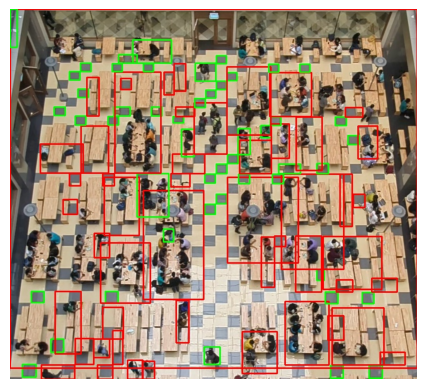

In [46]:
# Read the image
img = cv2.imread('C:/Users/HP/OneDrive - Shri Vile Parle Kelavani Mandal/Desktop/FOML/FomlProject/Processed/processed_frame_6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Thresholding Failed, So we used Roboflow to Manually Label all Images, After Manually Labeling we Imported the data and created our training data

In [3]:
# Load COCO JSON
with open('FOML-PROJECT-CANTEEN-EMPTY-TABLE.v1i.coco/train/_annotations.coco.json', 'r') as file:
    data = json.load(file)

# Extract relevant information
images = data['images']
annotations = data['annotations']
categories = data['categories']

# Assume you are classifying into "empty" and "occupied" categories
category_mapping = {category['id']: category['name'] for category in categories}

train_dataset = []

for image_info in images:
    if image_info['file_name'].endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join('FOML-PROJECT-CANTEEN-EMPTY-TABLE.v1i.coco/train/', image_info['file_name'])
        image = cv2.imread(image_path)
    
    image_annotations = [ann for ann in annotations if ann['image_id'] == image_info['id']]
    for ann in image_annotations:
        category = category_mapping[ann['category_id']]
        bbox = ann['bbox']
        xmin, ymin, width, height = bbox
        region = image[int(ymin):int(ymin+height), int(xmin):int(xmin+width)]
        
        # Here you can preprocess your region (resize, normalize, etc.)
        train_dataset.append((region, category))

# Extract train images and labels
X_train, y_train = zip(*train_dataset)


In [4]:
X_train[0]

array([[[ 94,  98,  99],
        [ 94,  98,  99],
        [ 95,  98, 102],
        ...,
        [ 83, 111, 135],
        [ 54,  82, 106],
        [ 58,  85, 106]],

       [[116, 125, 129],
        [115, 124, 128],
        [115, 124, 128],
        ...,
        [ 95, 123, 147],
        [ 82, 110, 134],
        [ 90, 117, 138]],

       [[175, 188, 196],
        [174, 187, 195],
        [173, 186, 194],
        ...,
        [112, 140, 164],
        [116, 144, 168],
        [126, 153, 174]],

       ...,

       [[117, 105, 101],
        [116, 105, 101],
        [117, 105, 101],
        ...,
        [ 61,  73,  91],
        [125, 141, 158],
        [146, 166, 184]],

       [[116, 104, 102],
        [114, 105, 102],
        [116, 104, 102],
        ...,
        [ 73,  85, 103],
        [128, 143, 162],
        [142, 162, 180]],

       [[112, 104, 104],
        [112, 105, 102],
        [113, 105, 105],
        ...,
        [ 78,  92, 111],
        [130, 145, 164],
        [139, 159, 177]]

In [4]:
y_train

('Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Occupied',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',
 'Empty',

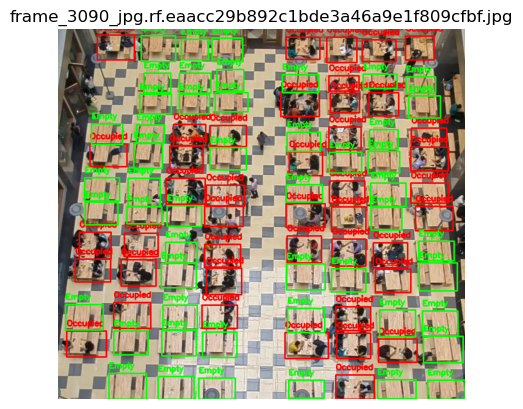

In [6]:
colors = {
    'Empty': (0, 255, 0),    # Green for 'Empty'
    'Occupied': (255, 0, 0)  # Red for 'Occupied'
}

image_index = 5  

# Load the image using the defined image index
image_path = os.path.join('FOML-PROJECT-CANTEEN-EMPTY-TABLE.v1i.coco/train/', images[image_index]['file_name'])
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  

image_annotations = [ann for ann in annotations if ann['image_id'] == images[image_index]['id']]

for ann in image_annotations:
    category = category_mapping[ann['category_id']]
    bbox = ann['bbox']
    xmin, ymin, width, height = bbox
    top_left = (int(xmin), int(ymin))
    bottom_right = (int(xmin+width), int(ymin+height))
    
    
    color = colors.get(category, (0, 0, 255))  
    
    cv2.rectangle(image, top_left, bottom_right, color, 2)
    
    cv2.putText(image, category, (int(xmin), int(ymin) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.title(images[image_index]['file_name'])

plt.imshow(image)
plt.axis('off')
plt.show()


In [7]:
# Define a standard size
standard_size = (100, 100)  # This can be changed based on your requirements

# Convert all regions (cropped images) to grayscale, resize them to standard size, and flatten
X_train_gray_flattened = [cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), standard_size).flatten() for img, label in train_dataset]
X_train_gray_flattened = np.array(X_train_gray_flattened)


In [8]:
X_train_gray_flattened.shape


(27585, 10000)

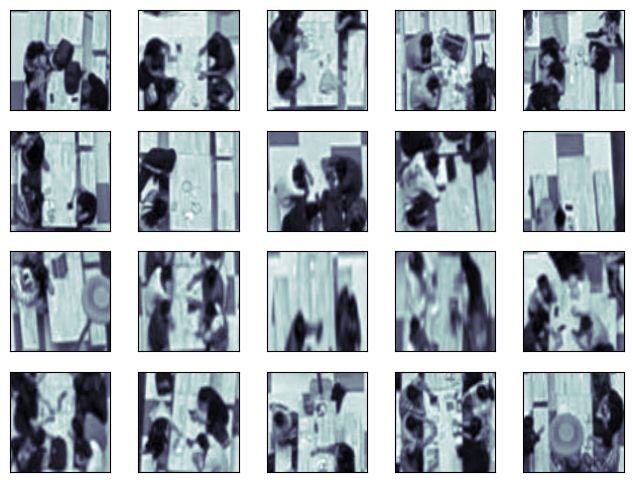

In [11]:
fig = plt.figure(figsize=(8,6))
for i in range(20):
    ax = fig.add_subplot(4,5,i+1,xticks=[],yticks=[])
    ax.imshow(X_train_gray_flattened[i].reshape(100,100),cmap=plt.cm.bone)

In [12]:
# Initialize PCA; set the number of components to keep 90% of variance
pca = PCA(0.9)
principalComponents = pca.fit_transform(X_train_gray_flattened)


In [13]:
principalComponents.shape

(27585, 125)

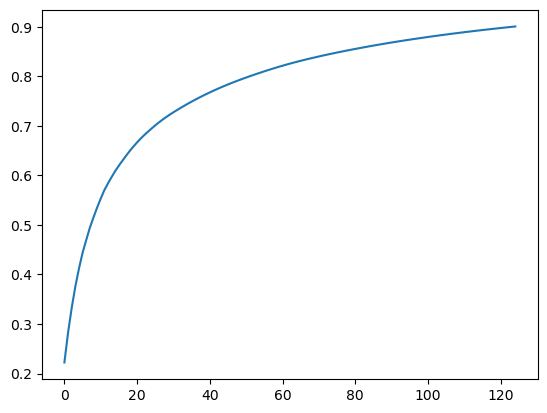

In [14]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [15]:
print(principalComponents)

[[ 1.66303301e+03  5.09661819e+02 -1.36466922e+02 ... -9.86735521e+01
  -3.37671680e+01  1.26687985e+02]
 [ 1.22291089e+03  2.58707574e+02 -3.14632434e+03 ... -4.10647987e+02
   2.02552950e+02  2.07580813e+02]
 [ 2.33822309e+02  2.54658412e+02 -2.26777195e+03 ... -1.54054249e+02
  -2.83198595e+02 -1.04046483e+02]
 ...
 [-1.52408535e+03 -3.68128431e+02  6.66115353e+02 ...  7.12409848e+01
  -5.44276748e+01  1.21228891e-01]
 [-2.47485337e+03  1.33500154e+02 -6.33840053e+02 ...  8.23726927e+01
   2.09565081e+02 -4.22964232e+01]
 [-1.11101313e+03 -2.28177436e+01 -1.13097143e+03 ... -1.22838742e+02
   5.73068697e+01 -3.19230121e+01]]


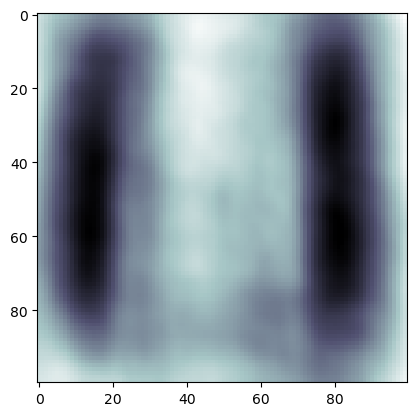

In [16]:
plt.imshow(pca.components_[0].reshape(100,100),cmap=plt.cm.bone)

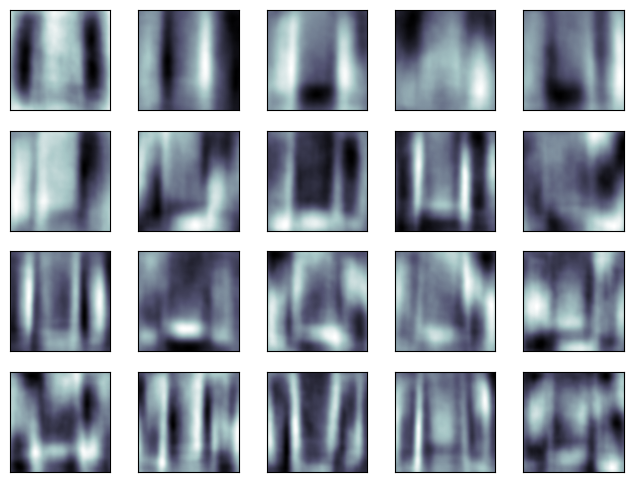

In [17]:
fig = plt.figure(figsize=(8,6))
for i in range(20):
    ax = fig.add_subplot(4,5,i+1,xticks=[],yticks=[])
    ax.imshow(pca.components_[i].reshape(100,100),cmap=plt.cm.bone)

In [18]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train_onehot = to_categorical(y_train_encoded)


In [19]:
print(y_train_onehot)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [20]:
# Defining the CNN model
model1 = Sequential()
model1.add(Dense(128, input_shape=(125,), activation='relu'))  # Adjusted input shape
model1.add(Dense(64, activation='relu'))
model1.add(Dense(2, activation='softmax'))  # Adjusted number of output neurons based on unique labels

# Compiling the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Displaying the model summary
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               16128     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 24514 (95.76 KB)
Trainable params: 24514 (95.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/30
920/920 [==============================] - 1s 431us/step - loss: 6.3978 - accuracy: 0.9548
Epoch 2/30
920/920 [==============================] - 0s 456us/step - loss: 1.2611 - accuracy: 0.9811
Epoch 3/30
920/920 [==============================] - 0s 455us/step - loss: 0.7090 - accuracy: 0.9857
Epoch 4/30
920/920 [==============================] - 0s 447us/step - loss: 0.5007 - accuracy: 0.9888
Epoch 5/30
920/920 [==============================] - 0s 467us/step - loss: 0.4499 - accuracy: 0.9877
Epoch 6/30
920/920 [==============================] - 0s 452us/step - loss: 0.2435 - accuracy: 0.9921
Epoch 7/30
920/920 [==============================] - 0s 443us/step - loss: 0.2223 - accuracy: 0.9924
Epoch 8/30
920/920 [==============================] - 0s 442us/step - loss: 0.1442 - accuracy: 0.9933
Epoch 9/30
920/920 [==============================] - 0s 425us/step - loss: 0.1048 - accuracy: 0.9941
Epoch 10/30
920/920 [==============================] - 0s 449us/step - loss: 0.111

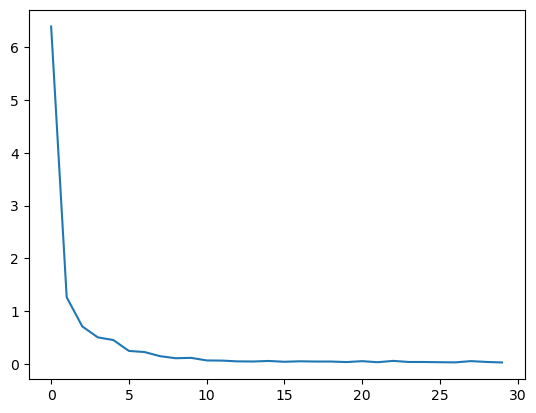

In [21]:
hist = model1.fit(principalComponents, y_train_onehot, epochs=30, batch_size=30)
plt.plot(hist.history['loss'])

In [22]:
model1.predict(principalComponents)

863/863 [==============================] - 0s 252us/step


array([[9.5557129e-01, 4.4428676e-02],
       [0.0000000e+00, 1.0000000e+00],
       [3.6052937e-35, 1.0000000e+00],
       ...,
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 6.9374623e-10],
       [1.0000000e+00, 3.3449114e-36]], dtype=float32)

In [23]:
# Predict probabilities for the test dataset
predictions_proba = model1.predict(principalComponents)

# Get the predicted class labels
predictions = np.argmax(predictions_proba, axis=1)

863/863 [==============================] - 0s 253us/step


In [24]:
test_y_NN = model1.predict(principalComponents)
y_pred = (test_y_NN>0.5).astype('int32')
print(y_pred)
original_labels = np.argmax(y_pred, axis=1)
print(original_labels)

863/863 [==============================] - 0s 257us/step
[[1 0]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]
[0 1 1 ... 0 0 0]


In [25]:
print(confusion_matrix(y_train_encoded, original_labels))
print(accuracy_score(y_train_encoded, original_labels))

[[15814    50]
 [  100 11621]]
0.9945622620989668


In [120]:
# Load the image
img_path = "C:/Users/HP/Downloads/Screenshot 2023-11-01 133143.png"
image = cv2.imread(img_path)

# Preprocess the image: resize, convert to grayscale, flatten, etc.
# Assuming preprocessing steps similar to your training data preprocessing
preprocessed_img = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), standard_size).flatten().reshape(1, -1)  # Assuming 'standard_size' is already defined

# Transform using PCA
test_pca = pca.transform(preprocessed_img)  # 'pca' should be the PCA object you used during training

# Predict using the trained model
predictions_proba = model1.predict(test_pca)
predicted_class = np.argmax(predictions_proba, axis=1)

# Label the image with the predicted class
label = "Predicted Class: " + str(predicted_class[0])  # Convert to string for display
cv2.putText(image, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)  # Adjust coordinates and font size as needed

# Display the labeled image
cv2.imshow('Labeled Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 0s 19ms/step


In [26]:
# Load the JSON file
with open('FOML-Project-Testing-Data.v1i.coco/train/_annotations.coco.json') as file:
    data = json.load(file)

# Function to get table coordinates
def get_table_coordinates(data, image_filename):
    coordinates = []
    # Find the image id corresponding to the filename
    image_id = None
    for image in data['images']:
        if image['file_name'] == image_filename:
            image_id = image['id']
            break
    
    # If image id is found, extract the coordinates
    if image_id is not None:
        for annotation in data['annotations']:
            if annotation['image_id'] == image_id:
                bbox = annotation['bbox']
                x, y, width, height = bbox
                coordinates.append(((x, y), (x+width, y+height)))
    return coordinates

# Get coordinates of tables in a specific image
image_filename = 'frame_30_jpg.rf.c4b0d56ef6fdd08fecc83d70c2013492.jpg'
table_coordinates = get_table_coordinates(data, image_filename)

table_coordinates


[((76, 98), (137.69, 136.69)),
 ((155, 102), (213.4, 145.9)),
 ((227, 102), (267.83, 145.32)),
 ((287, 106), (332.06, 140.63)),
 ((493, 102), (539.96, 138.18)),
 ((567, 96), (613.95, 138.94)),
 ((648, 99), (701.88, 135.18)),
 ((428, 161), (482.69, 201.57999999999998)),
 ((289, 162), (347.57, 197.76)),
 ((215, 164), (273.58, 204)),
 ((148, 160), (204.67000000000002, 196.14)),
 ((90, 208), (144.36, 249.32)),
 ((69, 265), (121.43, 303.4)),
 ((138, 268), (191.96, 302.73)),
 ((223, 262), (269.23, 300.2)),
 ((221, 305), (264.53, 338.40999999999997)),
 ((289, 263), (338.31, 300.24)),
 ((286, 301), (348.05, 341.35)),
 ((427, 303), (483.43, 342.92)),
 ((502, 267), (552.62, 302.69)),
 ((265, 644), (334.58, 691.33)),
 ((198, 607), (257.74, 642.39)),
 ((11, 600), (84.28, 649.09)),
 ((432, 599), (501.36, 645.39)),
 ((436, 643), (502.85, 693.5)),
 ((523, 644), (593.3, 693.64)),
 ((524, 600), (582.53, 647.55)),
 ((689, 602), (767, 657.65)),
 ((679, 505), (754.49, 557.04)),
 ((598, 521), (663.47, 563.

In [27]:
# Load the canteen image
canteen_img_path = "testdata/frame_30.jpg"
canteen_image = cv2.imread(canteen_img_path)

# Loop over each table coordinate
for coords in table_coordinates:
    (x1, y1), (x2, y2) = coords
    
    # Convert coordinates to integers
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
    
    # Crop the table image
    table_image = canteen_image[y1:y2, x1:x2]
    
    # Preprocess the table image
    preprocessed_img = cv2.resize(cv2.cvtColor(table_image, cv2.COLOR_BGR2GRAY), standard_size).flatten().reshape(1, -1)
    
    # Transform using PCA
    test_pca = pca.transform(preprocessed_img)
    
    # Predict using the trained model
    predictions_proba = model1.predict(test_pca)
    predicted_class = np.argmax(predictions_proba, axis=1)
    

    # Choose a color based on the prediction
    color = (0, 255, 0) if predicted_class[0] == 0 else (0, 0, 255)  # green for empty, red for occupied
    
    # Draw the bounding box on the canteen image
    cv2.rectangle(canteen_image, (x1, y1), (x2, y2), color, 2)

# Display the canteen image with the bounding boxes
cv2.imshow('Canteen Occupancy', canteen_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 0s 17ms/step


KeyboardInterrupt: 